<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<div style="text-align: center;">
<img src="../Imagenes/CUGDL_logo.png" alt="Drawing" style="width: 800px;"/>
</div>

<center> <span style="color:DarkBlue">  Tema 8. K Vecinos Cercanos: Introducción</span>  </center>
<center> <span style="color:Blue"> Profesor: M. en C. Iván A. Toledano Juárez </span>  </center>

## Introducción al modelo de K vecinos más cercanos (KNN)

El algoritmo de **K vecinos más cercanos (K-Nearest Neighbors, KNN)** es un método de **clasificación** (y también regresión) basado en la idea de **proximidad** entre instancias en el espacio de características. No requiere entrenamiento en el sentido tradicional, sino que **almacena los datos** y, al momento de predecir una nueva muestra, busca los **K ejemplos más cercanos** (según una métrica de distancia, comúnmente **euclidiana**) y asigna la clase **más común entre ellos**.

Dado un nuevo punto $\mathbf{x}$, el algoritmo:
1. Calcula las distancias $\|\mathbf{x} - \mathbf{x}_i\|$ a todos los puntos del conjunto de entrenamiento.
2. Selecciona los **K puntos más cercanos**.
3. Predice la clase $\hat{y}$ como la moda entre sus etiquetas:
\begin{equation}
\hat{y} = \operatorname{mode}\left\{ y_i \,:\, \mathbf{x}_i \in \text{vecinos más cercanos a } \mathbf{x} \right\}
\end{equation}

El valor de **K** controla el **nivel de suavidad** de la frontera de decisión:
- K pequeño → modelo más flexible, más sensible al ruido (**riesgo de sobreajuste**).
- K grande → modelo más estable, pero puede **subajustar** si se pierde información local.

KNN es un modelo **intuitivo, no paramétrico**: no aprende explícitamente una función, sino que **difiere el cálculo hasta el momento de predecir**. Es muy útil como primer modelo de referencia, aunque puede ser costoso computacionalmente para conjuntos de datos grandes.

In [1]:
# Importación de librerías

import os
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import style
style.use('ggplot')
import seaborn as sns
import pandas as pd
from scipy import stats


from sklearn.datasets import make_blobs, make_circles

,V1,V2,y
0,10.378027,11.564235,0
1,9.178276,7.976873,0
2,8.386222,10.739288,0
3,14.890201,13.683400,0
4,6.013596,12.713585,0
5,8.356196,8.296358,0
6,8.270420,8.453007,0
7,8.152035,8.541676,0
8,9.392085,9.307719,0
9,8.836975,7.231905,0


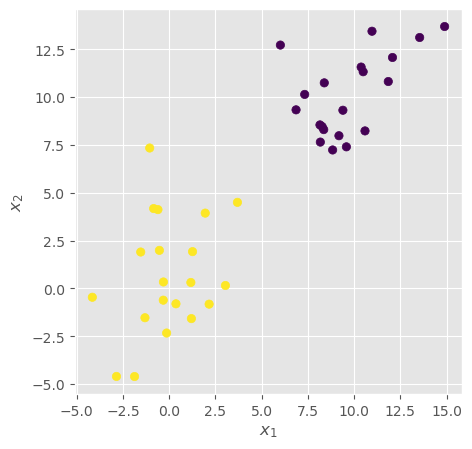

In [3]:
# Creamos puntos aleatorios

# Semilla aleatoria
np.random.seed(2023)

size = 20

a = np.random.multivariate_normal([10,10],[[3,1],[1,4]], size=[size,]) # normal en varias dimensiones

# generamos otras distribuciones
b = np.random.multivariate_normal([0,0],[[4,1],[1,5]], size=[size,])

x = np.arange(-2,12,0.1)

# Creamos el dataset
X = np.concatenate((a,b))

# Creamos un data frame y agregamos etiquetas a los puntos
data = pd.DataFrame(
{
    'V1':X[:,0],
    'V2':X[:,1]
})

data['y'] = np.where(data.index.values < size, 0, 1)
display(data)


# Plot
plt.figure(figsize=(5,5))
plt.scatter(data['V1'],data['V2'],c=data['y'])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
#plt.savefig('Plots/KNN_1.pdf', bbox_inches = 'tight')
plt.show()

## Variables predictoras y objetivo

In [4]:
predictors = data.columns.values.tolist()[:-1]
target = data.columns.values.tolist()[-1]

## Implementación manual

Generamos un nuevo vector de prueba (5,2.5) y sacamos las distancias a todos los puntos. El nuevo punto se muestra como una cruz roja.

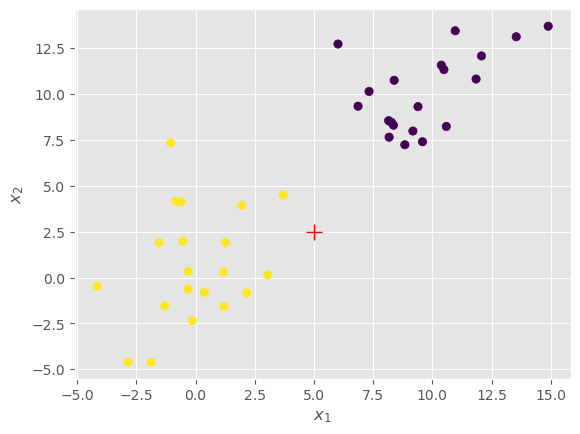

In [6]:
x_new = [5.0,2.5]

plt.scatter(data['V1'],data['V2'],c=data['y'])
plt.plot(x_new[0],x_new[1],color='red', marker='+', markersize=12)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

Vamos a utilizar la métrica euclidea $d = \sqrt{(x_1-x_1^t)^2 + (x_2 - x_2^t)^2 + (x_3 - x_3^t)^2 + (x_4 - x_4^t)^2 + \ldots}$ para calcular la distancia a otros puntos. 

In [10]:
# valores de referencia
x_new = [5.0,2.5] # nuevo vector
distances = [] # Guardamos la distancia contra todos los puntos
k = 10

# creamos lista distancias
# la ordenamos segun su distancia
# nos quedamos con las distancias y los indices correspondientes del dataframe original

for i in range(0,len(data)):
    row = data[predictors].iloc[i].to_numpy()
    diff = x_new - row
    dist = pow(diff,2)
    dist = np.sqrt(dist.sum())
    distances.append((dist,i))

distances = sorted(distances, key=lambda a: a[0]) # lista de tuplas (distancia,indice)

knn = distances[:k]
knn

[(np.float64(2.385523721073668), 38),
 (np.float64(3.0586696873922423), 35),
 (np.float64(3.3684267749507315), 39),
 (np.float64(3.7798174445963193), 37),
 (np.float64(4.372184356708227), 32),
 (np.float64(4.409519570407743), 24),
 (np.float64(5.550366953050173), 20),
 (np.float64(5.574135698033346), 21),
 (np.float64(5.691121015981601), 31),
 (np.float64(5.733849731170787), 30)]

In [11]:
# La votacion por clase
# Se utiliza la moda de esta votación
from scipy.stats import mode
categories = []
for neighbour in knn:
    index = neighbour[1]
    category = data[target].iloc[index]
    categories.append(category)
print(mode(categories, keepdims=True).mode[0])

1


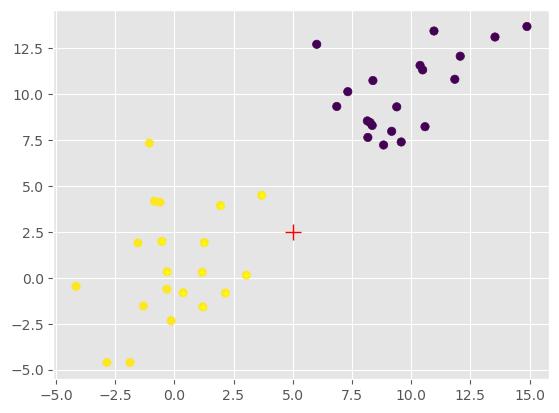

In [12]:
x_new = [5.0,2.5]

plt.scatter(data['V1'],data['V2'],c=data['y'])
plt.plot(x_new[0],x_new[1],color='red', marker='+', markersize=12)

for nb in knn:
    plt.plot(data['V1'].iloc[nb[1]],data['V2'].iloc[nb[1]],
             color='yellow',
             marker = '+',
             markersize=5)

plt.show()

In [13]:
# Podemos generalizar el proceso para cualquier punto nuevo
# distancia entre un punto nuevo y el los datos originales
# los vecinos más cercanos

def knn_dist_euclidea(data_x,data_y,x_new,k): # data_x = dataframe predictors, x = new point as array
    
    import numpy as np
    from scipy.stats import mode
    
    distances = []
    for i in range(0,len(data)):
        row = data_x.iloc[i].to_numpy()
        diff = x_new - row
        dist = pow(diff,2)
        dist = np.sqrt(dist.sum())
        distances.append((dist,i))
    distances = sorted(distances, key=lambda a: a[0])
    knn = distances[:k]
    
    categories = []
    for neighbour in knn:
        index = neighbour[1]
        category = data_y.iloc[index]
        categories.append(category)
        
    prediction = mode(categories, keepdims=True).mode[0]
    #print('predicted category =',prediction)

    return knn, prediction
    

In [14]:
knn_dist_euclidea(data_x=data[predictors],
              data_y=data[target],
              x_new=[5.0,2.5],
              k=10)

([(np.float64(2.385523721073668), 38),
  (np.float64(3.0586696873922423), 35),
  (np.float64(3.3684267749507315), 39),
  (np.float64(3.7798174445963193), 37),
  (np.float64(4.372184356708227), 32),
  (np.float64(4.409519570407743), 24),
  (np.float64(5.550366953050173), 20),
  (np.float64(5.574135698033346), 21),
  (np.float64(5.691121015981601), 31),
  (np.float64(5.733849731170787), 30)],
 np.int64(1))

## Ejemplo

In [15]:
def knn_dist_euclidea(data_x,data_y,x_new,k): # data_x = dataframe predictors, x = new point as array
    
    import numpy as np
    from scipy.stats import mode
    
    distances = []
    for i in range(0,len(data)):
        row = data_x.iloc[i].to_numpy()
        diff = x_new - row
        dist = pow(diff,2)
        dist = np.sqrt(dist.sum())
        distances.append((dist,i))
    distances = sorted(distances, key=lambda a: a[0])
    knn = distances[:k]
    
    categories = []
    for neighbour in knn:
        index = neighbour[1]
        category = data_y.iloc[index]
        categories.append(category)
        
    prediction = mode(categories, keepdims=True).mode[0]
    print('predicted category =',prediction)

    return knn, prediction

predicted category = 1


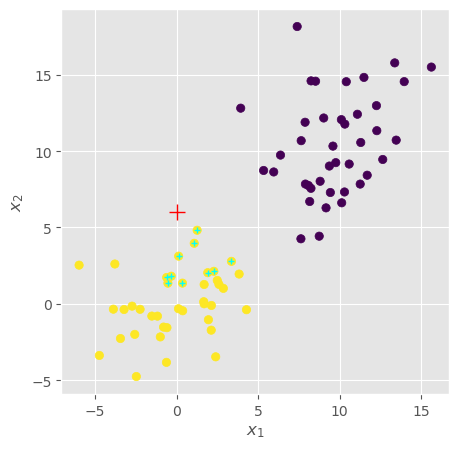

In [18]:
# Creamos puntos aleatorios

# Semilla aleatoria
np.random.seed(2023)

size = 40

a = np.random.multivariate_normal([10,10],[[5,1],[1,7]], size=[size,]) # normal en varias dimensiones

# generamos otras distribuciones
b = np.random.multivariate_normal([0,0],[[5,1],[1,6]], size=[size,])

x = np.arange(-2,12,0.1)

# Creamos el dataset
X = np.concatenate((a,b))

# Creamos un data frame y agregamos etiquetas a los puntos
data = pd.DataFrame(
{
    'V1':X[:,0],
    'V2':X[:,1]
})

data['y'] = np.where(data.index.values < size, 0, 1)

predictors = data.columns.values.tolist()[:-1]
target = data.columns.values.tolist()[-1]

# Dato nuevo
x_new = [0.0,6.0]

knn, pred = knn_dist_euclidea(data_x=data[predictors],
              data_y=data[target],
              x_new=x_new,
              k=10)


# Plot
plt.figure(figsize=(5,5))
plt.scatter(data['V1'],data['V2'],c=data['y'])
plt.plot(x_new[0],x_new[1],color='red', marker='+', markersize=12)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
for nb in knn:
    plt.plot(data['V1'].iloc[nb[1]],data['V2'].iloc[nb[1]],
             color='cyan',
             marker = '+',
             markersize=5)
#plt.savefig('Plots/KNN_1.pdf', bbox_inches = 'tight')
plt.show()